In [4]:
import json, os
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np
from itertools import combinations
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.decomposition import PCA
# from wpca import WPCA
from sklearn.preprocessing import StandardScaler
from aquabyte.accuracy_metrics import AccuracyMetricsGenerator
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
from aquabyte.visualize import Visualizer, _normalize_world_keypoints
# from template_matching import enhance, find_matches_and_homography, adjust_keypoints
import random
import pickle
import cv2
from copy import copy
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, Manager
import pyarrow.parquet as pq
import seaborn as sns

import matplotlib.cm as cm
pd.set_option('display.max_rows', 500)

In [5]:
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_SQL_CREDENTIALS'])))
query = """
    select adult_female_count, moving_count, fixed_count, unsure_count, work_duration_ms from lati_fish_detections_lice_annotations where adult_female_count >= 0;
"""
ldf = rds_access_utils.extract_from_database(query)

In [6]:
ldf['total_count'] = ldf.adult_female_count + ldf.moving_count + ldf.fixed_count + ldf.unsure_count


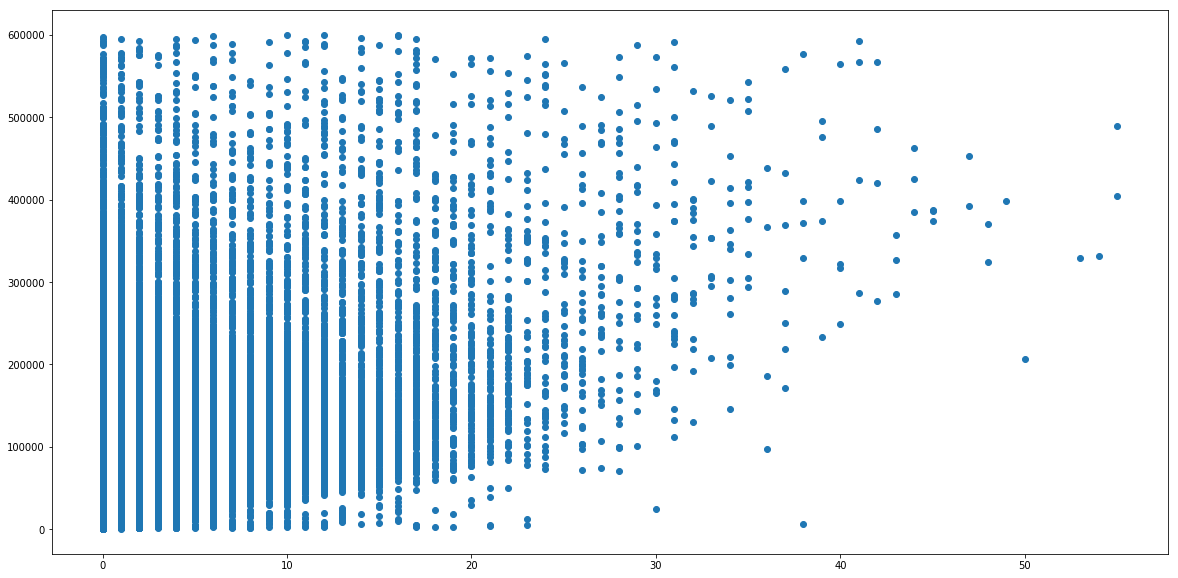

In [7]:
plt.figure(figsize=(20, 10))
mask = (ldf.work_duration_ms > 0) & (ldf.work_duration_ms < 10*60*1000)
plt.scatter(ldf[mask].moving_count, ldf[mask].work_duration_ms)
plt.show()

In [8]:
adult_female_counts = list(ldf[mask].groupby('adult_female_count')['work_duration_ms'].mean().index)
durations_f = list(ldf[mask].groupby('adult_female_count')['work_duration_ms'].mean().values)
moving_counts = list(ldf[mask].groupby('moving_count')['work_duration_ms'].mean().index)
durations_m = list(ldf[mask].groupby('moving_count')['work_duration_ms'].mean().values)

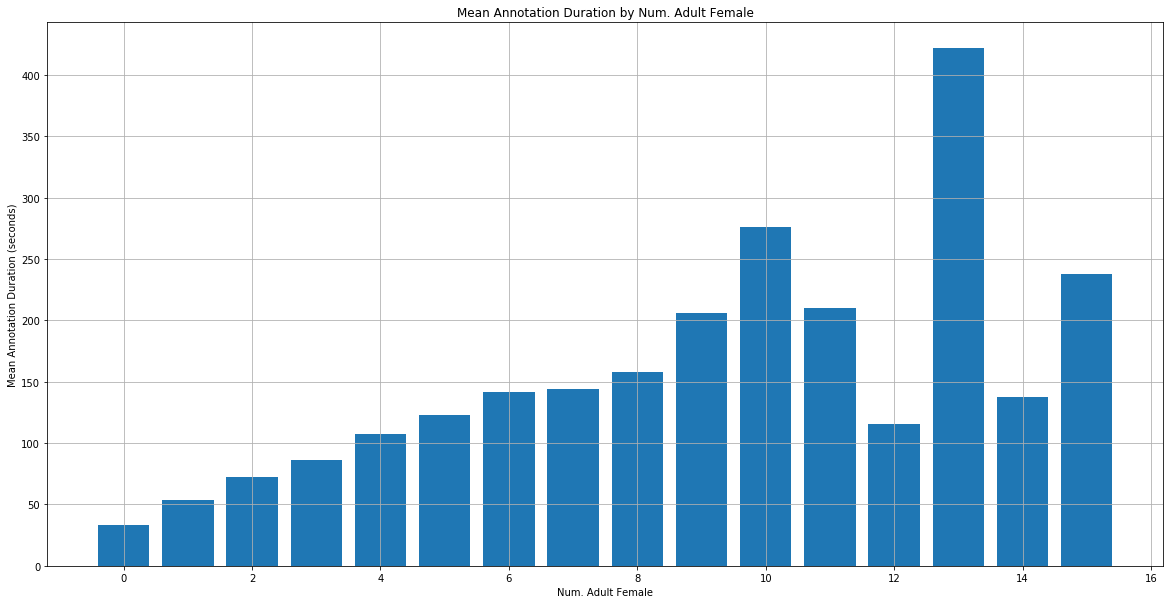

In [9]:
plt.figure(figsize=(20, 10))
plt.bar(adult_female_counts, np.array(durations_f) / 1e3)
plt.title('Mean Annotation Duration by Num. Adult Female')
plt.xlabel('Num. Adult Female')
plt.ylabel('Mean Annotation Duration (seconds)')
plt.grid()
plt.show()


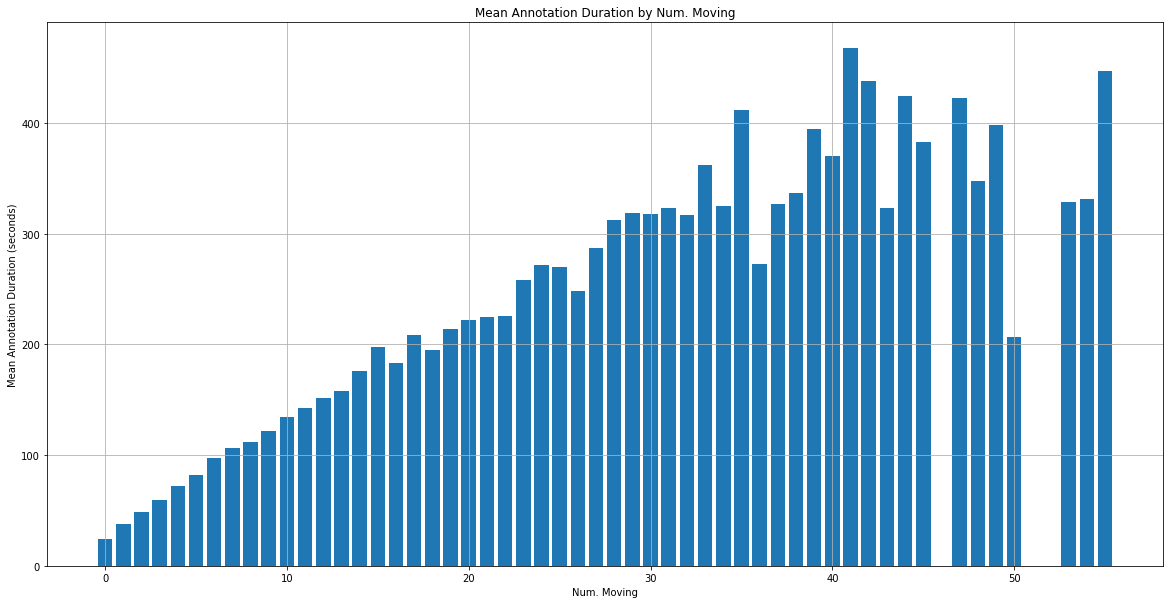

In [10]:
plt.figure(figsize=(20, 10))
plt.bar(moving_counts, np.array(durations_m) / 1e3)
plt.title('Mean Annotation Duration by Num. Moving')
plt.xlabel('Num. Moving')
plt.ylabel('Mean Annotation Duration (seconds)')
plt.grid()
plt.show()


In [47]:
ldf[mask].shape[0]

0

In [50]:
adult_female_counts = list(np.arange(0, 15, 1))
moving_counts = list(np.arange(0, 55, 1))
data = np.zeros([len(adult_female_counts), len(moving_counts)])
sample_size_data = np.zeros([len(adult_female_counts), len(moving_counts)])
for adult_female_count in adult_female_counts:
    for moving_count in moving_counts:
        mask = (ldf.work_duration_ms > 0) & (ldf.work_duration_ms < 10*60*1000) & \
            (ldf.adult_female_count == adult_female_count) & (ldf.moving_count == moving_count)
        mean_duration = ldf[mask].work_duration_ms.mean() / 1e3
        data[adult_female_count, moving_count] = mean_duration
        sample_size_data[adult_female_count, moving_count] = ldf[mask].shape[0]
#         print(mean_duration, ldf[mask].shape[0])
        
        

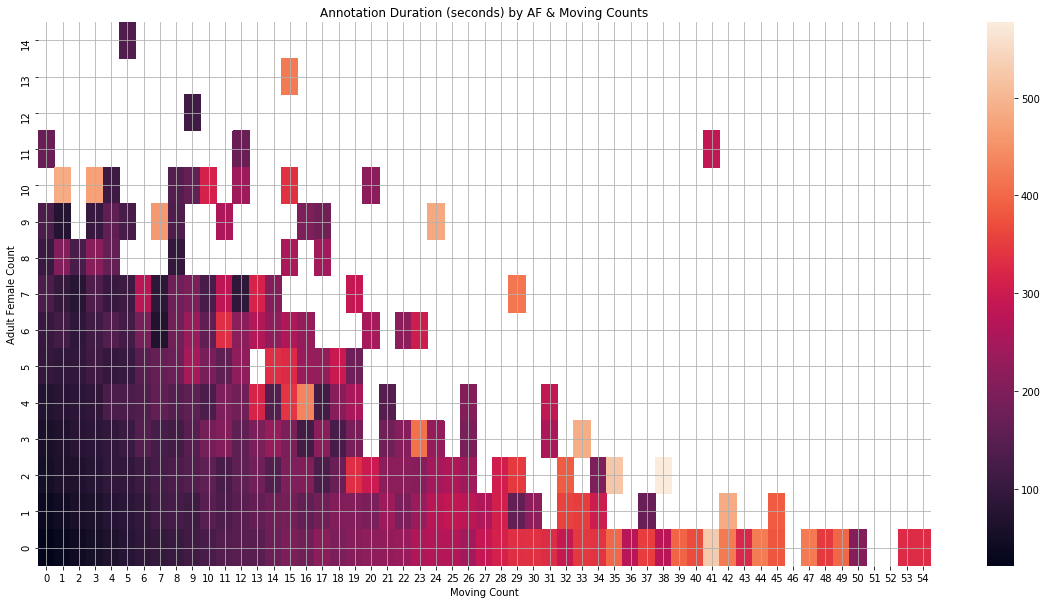

In [37]:
plt.figure(figsize=(20, 10))
sns.heatmap(data[list(reversed(range(data.shape[0])))], yticklabels=list(reversed(range(data.shape[0]))))
plt.xlabel('Moving Count')
plt.ylabel('Adult Female Count')
plt.title('Annotation Duration (seconds) by AF & Moving Counts')
plt.grid()
plt.show()

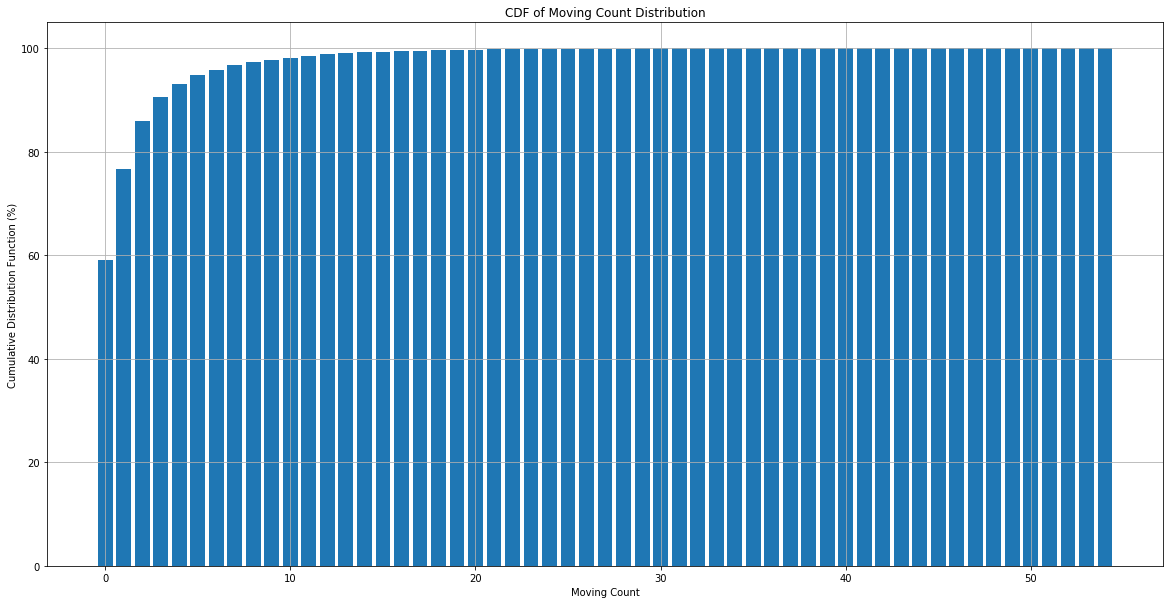

In [91]:
base_mask = (ldf.work_duration_ms > 0) & (ldf.work_duration_ms < 10*60*1000)
pcts = []
for moving_count in moving_counts:
    mask = base_mask & (ldf.moving_count <= moving_count)
    pct = ldf[mask].shape[0] / ldf[base_mask].shape[0]
    pcts.append(pct)

plt.figure(figsize=(20, 10))
plt.bar(moving_counts, np.array(pcts) * 1e2)
plt.xlabel('Moving Count')
plt.ylabel('Cumulative Distribution Function (%)')
plt.title('CDF of Moving Count Distribution')
plt.grid()
plt.show()

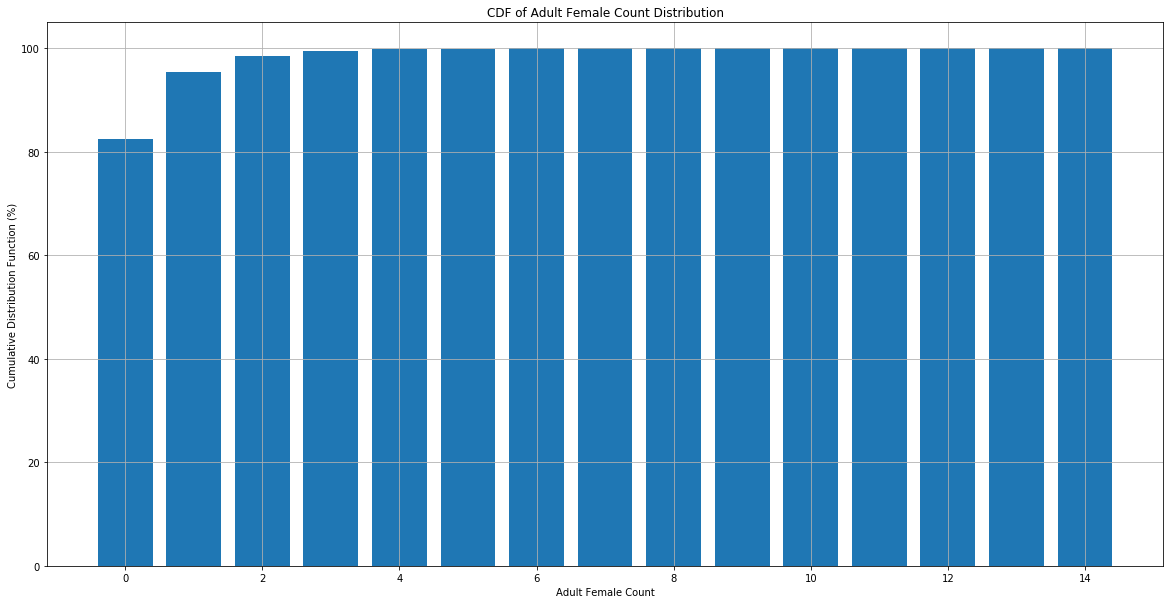

In [92]:
base_mask = (ldf.work_duration_ms > 0) & (ldf.work_duration_ms < 10*60*1000)
pcts = []
for adult_female_count in adult_female_counts:
    mask = base_mask & (ldf.adult_female_count <= adult_female_count)
    pct = ldf[mask].shape[0] / ldf[base_mask].shape[0]
    pcts.append(pct)

plt.figure(figsize=(20, 10))
plt.bar(adult_female_counts, np.array(pcts) * 1e2)
plt.xlabel('Adult Female Count')
plt.ylabel('Cumulative Distribution Function (%)')
plt.title('CDF of Adult Female Count Distribution')
plt.grid()
plt.show()